In [1]:
%matplotlib inline
import sys
from pathlib import Path
import numpy as np
from scipy import optimize
from matplotlib import colors, ticker

import betterplotlib as bpl
bpl.set_style()

In [2]:
home_dir = Path("./").resolve().parent
mrr_dir = home_dir / "analysis" / "mass_radius_relation"
sys.path.append(str(mrr_dir))
import mass_radius_utils as mru
import mass_radius_utils_mle_fitting as mru_mle
import mass_radius_utils_plotting as mru_p

# Create a mass-size relation that's just the fit for the 1-10 Myr bin

In [3]:
def mass_size_relation(mass, beta, r_4):
    return r_4 * (mass / 10**4)**beta

In [20]:
beta, r_4 = 0.18, 2.365, 
test_masses = np.logspace(3, 5, 100)
test_radii = mass_size_relation(test_masses, beta, r_4)

# Create simple fitting program

In [21]:
def negative_log_likelihood(params, xs, ys):
    # first convert the pivot point value into the intercept
    pivot_point_x = 4
    # so params[1] is really y(pivot_point_x) = m (pivot_point_x) + intercept
    intercept = params[1] - params[0] * pivot_point_x

    # calculate the difference 
    data_diffs = (ys - (params[0] * xs + intercept))

    # calculate the sum of data likelihoods. The total likelihood is the product of
    # individual cluster likelihoods, so when we take the log it turns into a sum of
    # individual log likelihoods. 
    return np.sum(data_diffs**2)

def fit_mass_size_relation(mass, r_eff):
    log_mass = np.log10(mass)
    log_r_eff = np.log10(r_eff)

    # Then try the fitting
    best_fit_result = optimize.minimize(
        negative_log_likelihood,
        args=(
            log_mass,
            log_r_eff,
        ),
        bounds=([-1, 1], [None, None]),
        x0=np.array([0.2, np.log10(2)]),
    )
    assert best_fit_result.success
    beta = best_fit_result.x[0]
    r_4 = 10**best_fit_result.x[1]
    return beta, r_4

# Create methods to simulate disruption from various methods

In [22]:
def stellar_mass_adiabatic(m_old, m_new, r_old):
    # Portegies Zwart et al. 2010 section 4.3.1 Eq 33
    # Krumholz review section 3.5.2
    r_new = r_old * m_old / m_new
    return r_new

def stellar_mass_rapid(m_old, m_new, r_old):
    # Portegies Zwart et al. 2010 section 4.2.1 Eq 31
    # Krumholz review section 3.5.2
    eta = m_new / m_old
    r_new = r_old * eta / (2 * eta - 1)
    return r_new

In [23]:
mass_stellar_evol = test_masses * 0.5  
# at 1 Gyr 0.6 is the expected loss, Krumholz review section 4.2.1
radii_stellar_evol = stellar_mass_adiabatic(test_masses, mass_stellar_evol, test_radii)

fit_stellar_evol = fit_mass_size_relation(mass_stellar_evol, radii_stellar_evol)

In [24]:
def tidal_radius(m_old, m_new, r_old):
    # Krumholz review Equation 9 section 1.3.2
    consts = r_old**3 / m_old
    r_new = (consts * m_new) **(1/3)
    return r_new

In [25]:
mass_tidal = test_masses * 0.5   # arbitrary value
radii_tidal = tidal_radius(test_masses, mass_tidal, test_radii)

fit_tidal = fit_mass_size_relation(mass_tidal, radii_tidal)

# Then plot how that changes things

In [26]:
def format_params(base_label, beta, r_4):
    return f'{base_label} - $\\beta={beta:.3f}, r_4={r_4:.3f}$'

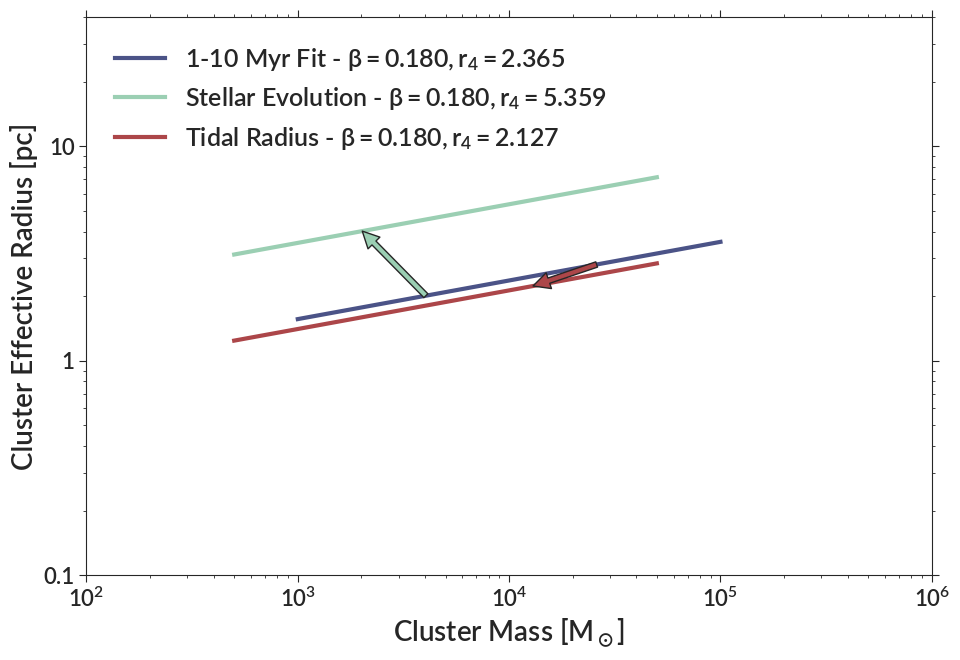

In [28]:
fig, ax = bpl.subplots()
ax.plot(test_masses, test_radii, label=format_params("1-10 Myr Fit", beta, r_4))
ax.plot(mass_stellar_evol, radii_stellar_evol, 
        label=format_params("Stellar Evolution", fit_stellar_evol[0], fit_stellar_evol[1]))
ax.plot(mass_tidal, radii_tidal, c=bpl.color_cycle[3],
        label=format_params("Tidal Radius", fit_tidal[0], fit_tidal[1]))

# draw arrows
arrow_idx = 30
ax.annotate("", xy=(mass_stellar_evol[arrow_idx], radii_stellar_evol[arrow_idx]),
            xytext=(test_masses[arrow_idx], test_radii[arrow_idx]),
            arrowprops={"edgecolor": bpl.almost_black, "facecolor": bpl.color_cycle[1]})
arrow_idx = 70
ax.annotate("", xy=(mass_tidal[arrow_idx], radii_tidal[arrow_idx]),
            xytext=(test_masses[arrow_idx], test_radii[arrow_idx]),
            arrowprops={"edgecolor": bpl.almost_black, "facecolor": bpl.color_cycle[3]})

mru_p.format_mass_size_plot(ax)
fig.savefig("mass_loss.png")